In [100]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline


In [101]:
from file_cache import *
os.environ["CUDA_VISIBLE_DEVICES"] = "1"


In [102]:
df = pd.read_csv('/home/felix/pj/thyroid_seg/input/TNSCUI2020_train/train.csv')
print(df.shape)
df.head()

(3644, 2)


,ID,CATE
0,5189.PNG,0
1,2090.PNG,1
2,5156.PNG,0
3,8303.PNG,1
4,9650.PNG,1


In [103]:
df.CATE.value_counts()

1    2003
0    1641
Name: CATE, dtype: int64

In [104]:
from fastai.vision import *
from fastai.callbacks.hooks import *

In [105]:

from file_cache import *

img_file_list = glob('/home/felix/pj/thyroid_seg/input/TNSCUI2020_train/image/*.PNG', recursive=True)

df = pd.DataFrame({'img_file':img_file_list})

df['label_path'] = df.img_file.apply(lambda val: val.replace('image', 'mask'))
df['sn'] = df.img_file.apply(lambda val: os.path.basename(val).split('.')[0]  ).astype(int)
df = df.sort_values('sn')

df['valid'] = df.sn%5 >=4
df.head()

df['size1'] = df.label_path.apply(lambda val: cv2.imread(val).shape[0])
df['size2'] = df.label_path.apply(lambda val: cv2.imread(val).shape[1])
df.sort_values('size1')

codes = list(range(2))
print('codes', list(codes) )




codes [0, 1]


In [106]:
np.unique(cv2.imread(df.iloc[0,1]), return_counts=True)

(array([0, 1], dtype=uint8), array([866472,   6438]))

In [107]:
# for file in df.label_path:
#     #print(file)
#     img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
#     #print(img.shape)
#     cv2.imwrite(file, img/max(1, img.max()) )

## Datasets

In [108]:
size =224
bs = 4
print('size, bs', size, bs)

src = (SegmentationItemList.from_df(df, path='/', cols='img_file' )
       .split_from_df(col='valid')
       .label_from_df(cols='label_path', classes=codes)
      )

print(len(src.train), len(src.valid), codes)

#get_transforms()
data = (src.transform(None, size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

size, bs 224 4
2942 702 [0, 1]


In [109]:
test_data = ImageList.from_folder(path="/share/data2/body/thyroid/test/image")
data.add_test(test_data, tfm_y=False)

In [110]:
# test_data = ImageList.from_folder(path="./input/test/image/")
# data.add_test(test_data)


In [111]:
# tmp = df.groupby(['p_id', 'valid'], as_index=False).label_path.count()
# tmp.pivot_table(index='p_id', columns='valid', values='label_path').sort_values(0)

In [112]:
for a, b in data.dl(DatasetType.Train):
    break
    
a.shape

torch.Size([4, 3, 224, 224])

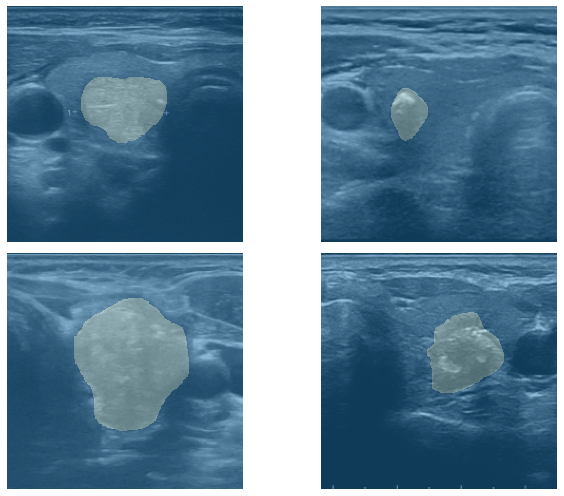

In [113]:
data.show_batch(8, figsize=(10, 7))

## Model

In [114]:
# name2id = {v:k for k,v in enumerate(codes)}
# #void_code = name2id['Void']

# def acc_camvid(input, target):
#     target = target.squeeze(1)
#     mask = target != void_code
#     return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [115]:
wd = 1e-2


In [116]:
print('abc', data.c)

abc 2


In [117]:
#多类别的Dice Metrics

from brain.metrics import * 

from functools import partial
def dice_fn(cls_id):
    fn = partial(dice_multiply, cls_id=cls_id) 
    fn.__name__ = f'dice_{cls_id}'
    return fn
 

#metrics = [ dice_fn(i) for i in codes ] #, accuracy,
#print('len=', len(metrics))
#import ipdb
# ipdb.set_trace()
# learn = unet_learner(data, models.resnet50, metrics=metrics , wd=wd)

# for sn, child in enumerate(learn.model.children()):
#     print(sn, '===', child)

In [118]:
from dynamic_unet.base import *
attention=True
def unet_learner(data:DataBunch, pretrained:bool=True, blur_final:bool=True,
                 norm_type:Optional[NormType]=None, split_on:Optional[SplitFuncOrIdxList]=None, blur:bool=False,
                 self_attention:bool=False, y_range:Optional[Tuple[float,float]]=None, last_cross:bool=True,
                 bottle:bool=False, cut:Union[int,Callable]=None, **learn_kwargs:Any)->Learner:
    

    encoder = nn.Sequential(*list(models.densenet121(pretrained=True).children())[0])
    #encoder = nn.Sequential(*list(models.(pretrained=True).children())[0])
    unet = DynamicUnet(encoder, n_classes=2, img_size=(224, 224), blur=False, blur_final=False,
                        self_attention=attention, y_range=None, norm_type=NormType,
                        last_cross=True,
                        bottle=False)
 
    learn = Learner(data, unet, **learn_kwargs)
    return learn

metrics = [ dice_fn(1), partial(dice, iou=True) ]
learn = unet_learner(data, metrics=metrics, wd=wd)

    sn        layer     c    w    h               size
2    2         ReLU    64  112  112  (1, 64, 112, 112)
4    4  _DenseBlock   256   56   56   (1, 256, 56, 56)
6    6  _DenseBlock   512   28   28   (1, 512, 28, 28)
8    8  _DenseBlock  1024   14   14  (1, 1024, 14, 14)
11  11  BatchNorm2d  1024    7    7    (1, 1024, 7, 7)


In [119]:
os.path.abspath('./output/model')

'/share/felix/pj/thyroid_seg/output/model'

In [120]:

learn.model_dir=os.path.abspath('./output/model')
os.makedirs(learn.model_dir, exist_ok=True)
learn.lr_find()

epoch,train_loss,valid_loss,dice_1,dice,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


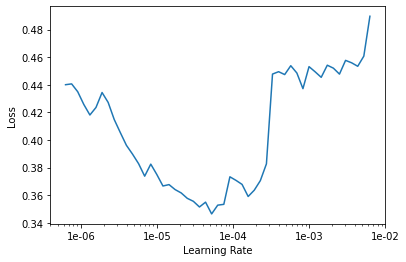

In [121]:
learn.recorder.plot()

In [122]:
print('bs=', bs, 'attention=', attention)
for _ in trange(2):
    lr = 1e-4
    learn.fit_one_cycle(5, slice(lr), pct_start=0.9)

bs= 4 attention= True
  0%|          | 0/2 [00:00<?, ?it/s]

epoch,train_loss,valid_loss,dice_1,dice,time
0,0.161762,0.128552,0.488218,0.392070,05:39
1,0.118094,0.100141,0.682359,0.576367,05:34
2,0.093658,0.085811,0.783242,0.680000,05:40
3,0.095532,0.104036,0.729476,0.630257,05:40
4,0.050492,0.096359,0.826701,0.737945,05:41


 50%|█████     | 1/2 [28:15<28:15, 1695.88s/it]

epoch,train_loss,valid_loss,dice_1,dice,time
0,0.039655,0.083924,0.829382,0.743302,05:40
1,0.038604,0.084455,0.849980,0.763228,05:41
2,0.044277,0.114756,0.818012,0.728352,05:41
3,0.054125,0.112458,0.824909,0.734441,05:40
4,0.035196,0.224209,0.845342,0.762344,05:36


100%|██████████| 2/2 [56:36<00:00, 1698.27s/it]


In [99]:
print('bs=', bs, 'attention=', attention)
for _ in trange(2):
    lr = 1e-4
    learn.fit_one_cycle(5, slice(lr), pct_start=0.9)

bs= 2
  0%|          | 0/2 [00:00<?, ?it/s]

epoch,train_loss,valid_loss,dice_1,dice,time
0,0.141767,0.124045,0.607516,0.498063,07:20
1,0.162214,0.204499,0.607801,0.487713,07:27
2,0.095029,0.097368,0.754569,0.651435,07:24
3,0.072159,0.109935,0.781187,0.684080,07:18
4,0.049829,0.079762,0.833840,0.745844,07:24


 50%|█████     | 1/2 [36:54<36:54, 2214.84s/it]

epoch,train_loss,valid_loss,dice_1,dice,time
0,0.043656,0.067972,0.837230,0.751796,07:17
1,0.047742,0.074830,0.830421,0.740676,07:21
2,0.042055,0.082497,0.821259,0.728216,07:21
3,0.068437,0.085831,0.780868,0.681235,07:21
4,0.040937,0.122417,0.838483,0.754384,07:25


100%|██████████| 2/2 [1:13:43<00:00, 2211.77s/it]


In [76]:
print('bs=', bs)
for _ in trange(2):
    lr = 1e-4
    learn.fit_one_cycle(5, slice(lr), pct_start=0.9)

bs= 2
  0%|          | 0/2 [00:00<?, ?it/s]

epoch,train_loss,valid_loss,dice_1,dice,time
0,0.156576,0.228339,0.155657,0.107259,06:57
1,0.095832,0.120239,0.689975,0.597365,06:54
2,0.107074,0.097350,0.741897,0.634993,06:48
3,0.093511,0.110878,0.746393,0.646623,06:51
4,0.049501,0.145378,0.806663,0.719434,07:08


 50%|█████     | 1/2 [34:41<34:41, 2081.16s/it]

epoch,train_loss,valid_loss,dice_1,dice,time
0,0.044333,0.157447,0.814171,0.728642,07:12
1,0.047996,0.102467,0.800266,0.714403,07:13
2,0.050844,0.079448,0.812767,0.722740,07:09
3,0.069162,0.094361,0.803596,0.715757,07:11
4,0.033926,0.082081,0.824517,0.739532,07:17


100%|██████████| 2/2 [1:10:45<00:00, 2122.71s/it]


---
# batch test END

# TODO
## OHEM

In [124]:
lr = 1e-4
print('bs=', bs, 'attention=', attention)
learn.fit_one_cycle(5, slice(lr), pct_start=0.9)

bs= 4 attention= True


epoch,train_loss,valid_loss,dice_1,dice,time
0,0.028693,0.102509,0.849790,0.767680,05:14
1,0.030716,0.083327,0.853549,0.772632,05:25
2,0.042893,0.091491,0.819497,0.730872,05:27
3,0.036342,0.076468,0.838749,0.749602,05:31
4,0.030025,0.206356,0.849783,0.767786,05:36


In [125]:
lr = 1e-4
print('bs=', bs, 'attention=', attention)
learn.fit_one_cycle(5, slice(lr), pct_start=0.9)

bs= 4 attention= True


epoch,train_loss,valid_loss,dice_1,dice,time
0,0.025306,0.134076,0.854392,0.773820,05:36
1,0.025651,0.157944,0.857569,0.775176,05:28
2,0.026869,0.102275,0.848274,0.761690,05:39
3,0.030738,0.104630,0.847579,0.759414,05:36
4,0.026750,0.090659,0.850974,0.770736,05:26


In [126]:
lr = 1e-4
print('bs=', bs, 'attention=', attention)
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

bs= 4 attention= True


epoch,train_loss,valid_loss,dice_1,dice,time
0,0.028868,0.091447,0.859781,0.780239,05:24
1,0.019990,0.107896,0.861697,0.781603,05:27
2,0.020580,0.099178,0.858991,0.776712,05:28
3,0.019054,0.117033,0.860155,0.778492,05:29
4,0.022021,0.139001,0.857647,0.776645,05:28
5,0.024509,0.098230,0.847586,0.760673,05:26
6,0.019960,0.098757,0.831841,0.745544,05:27
7,0.023878,0.117299,0.850580,0.765212,05:25
8,0.022080,0.125512,0.845396,0.760092,05:25
9,0.016095,0.112086,0.857649,0.775671,05:26


In [129]:
lr = 1e-4
print('bs=', bs, 'attention=', attention)
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

bs= 4 attention= True


epoch,train_loss,valid_loss,dice_1,dice,time
0,0.010418,0.135160,0.854552,0.771298,05:18
1,0.011683,0.123089,0.858261,0.774247,05:26
2,0.010273,0.153114,0.849265,0.765485,05:26
3,0.010627,0.190509,0.843722,0.759928,05:26
4,0.011908,0.162392,0.855591,0.770447,05:30
5,0.023645,0.098406,0.836051,0.748807,05:29
6,0.014491,0.106987,0.849110,0.763568,05:32
7,0.015733,0.181165,0.840380,0.754988,05:28
8,0.012757,0.111166,0.852370,0.767076,05:25
9,0.008604,0.154156,0.851491,0.768244,05:34


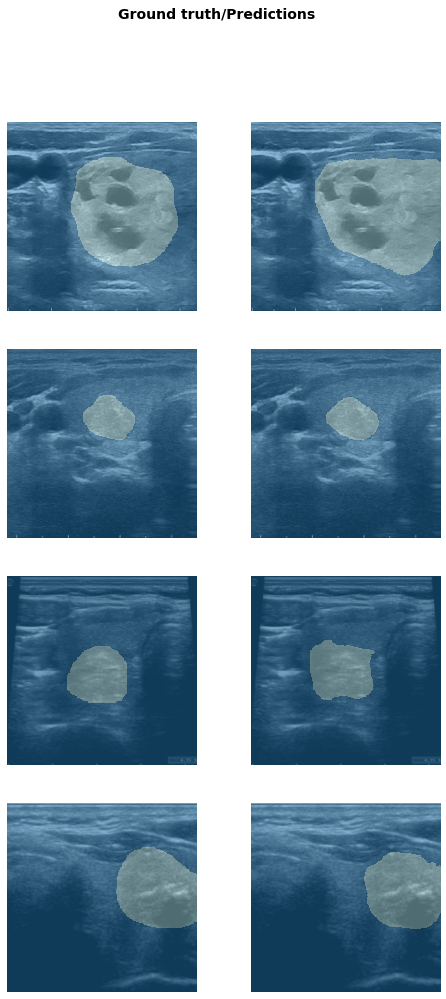

In [128]:
learn.show_results(DatasetType.Valid, rows=40)


In [132]:
dir(learn)

['TTA',
 '__annotations__',
 '__class__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__post_init__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_test_writeable_path',
 'add_time',
 'apply_dropout',
 'backward',
 'bn_wd',
 'callback_fns',
 'callbacks',
 'clip_grad',
 'create_opt',
 'data',
 'destroy',
 'dl',
 'export',
 'fit',
 'fit_fc',
 'fit_one_cycle',
 'freeze',
 'freeze_to',
 'get_preds',
 'init',
 'interpret',
 'layer_groups',
 'load',
 'loss_func',
 'lr_find',
 'lr_finder',
 'lr_range',
 'metrics',
 'mixup',
 'model',
 'model_dir',
 'one_cycle_scheduler',
 'opt',
 'opt_func',
 'path',
 'pred_batch',
 'predict',
 'predict_with_mc_dropout',
 'purge',
 'recorder',
